In [4]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer

import warnings 
warnings.filterwarnings(action='ignore')

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
def check_missing_col(df):
    missing_col = []
    for col in df.columns:
        missing_values = sum(df[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col}입니다')
            print(f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다')
            missing_col.append([col, df[col].dtype])
        if missing_col == []:
            print('결측치가 존재하지 않습니다')
        return missing_col

In [7]:
missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


In [8]:
missing_col = check_missing_col(test)

결측치가 존재하지 않습니다


In [9]:
def clean_text(texts):
    corpus = []
    for i in range(len(texts)):
        review = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',texts[i]) #@%*=()/+ 와 같은 문장부호 제거
        review = re.sub(r'\d+','', review)#숫자 제거
        review = review.lower() #소문자 변환
        review = re.sub(r'\s+', ' ', review) #extra space 제거
        review = re.sub(r'<[^>]+>','',review) #Html tags 제거
        review = re.sub(r'\s+', ' ', review) #spaces 제거
        review = re.sub(r"^\s+", '', review) #space from start 제거
        review = re.sub(r'\s+$', '', review) #space from the end 제거
        review = re.sub(r'_', ' ', review) #space from the end 제거
        corpus.append(review) 
    return corpus

In [10]:
train.head()

,id,text,target
0,0,"\nThey were, and even if Washington might cons...",10
1,1,"We run ""SpaceNews & Views"" on our STAREACH BBS...",14
2,2,\n\n\nNot to worry. The Masons have been demo...,19
3,3,"Only Brendan McKay, or maybe ARF, would come t...",17
4,4,Help: I am running some sample problems from O...,5


In [11]:
train['text'] = clean_text(train['text'])

In [12]:
test['text'] = clean_text(test['text'])

In [13]:
# 문장 길이 분포도 확인
train['doc_len'] = train['text'].apply(lambda x:len(x.split()))

In [14]:
def plot_doc_lengths(df):
  mean_seq_len = np.round(df['doc_len'].mean()).astype(int)
  sns.distplot(tuple(df['doc_len']), hist=True, kde=True, label='lengths')
  plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'mean:{mean_seq_len}')
  plt.title('lengths')
  plt.legend()
  plt.show()
  print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어")

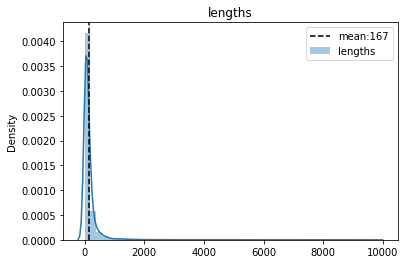

 가장 긴 문장은 9771 개의 단어, 가장 짧은 문장은 0 개의 단어


In [15]:
plot_doc_lengths(train)

In [16]:
# 2. Vectorization
# 2-1. Tokenization
# 인덱스 없이 배열로 만들기
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
Y_train = np.array([x for x in train['target']])

In [17]:
# tokenizer는 데이터에 있는 모든 단어의 개수를 세고 빈도 수를 정렬해서 num_words에 지정된 만큼만 숫자로 반환하고 나머지는 0으로 반환
vocab_size = 2000
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train) # tokenizer에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train) # 문장 내 모든 단어를 시퀸스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)

print (len(sequences_train), len(sequences_test))

9233 9233


In [18]:
# 3. Embedding
# 변환된 시퀸스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index

In [19]:
# 독립변수 데이터 전처리
# 문장의 길이가 제각각이기 때문에 벡터 크기 다 다름
# 그러므로 최대 시퀸스 길이 크기(211)만큼 넉넉하게 늘리고 패딩 작업을 통해 나머지 빈 공간을 0으로 채움
max_length = 2000
padding_type = 'post'

pad_X_train = pad_sequences(sequences_train, padding='post', maxlen=max_length)
pad_X_test = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

In [20]:
# 종속변수 데이터 전처리
onehot_Y_train = np_utils.to_categorical(Y_train)

In [21]:
# 4. Modeling
# 4-1. simple RNN
vocab_size = 2000
embedding_dim = 200
max_length = 2000
padding_type='post'

In [22]:
# simple rnn레이어를 사용한 모델 정의
model1 = Sequential([Embedding(vocab_size, embedding_dim, input_length=max_length),
                     tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
                     tf.keras.layers.SimpleRNN(units=64, return_sequences=True),
                     tf.keras.layers.SimpleRNN(units=64),
                     Dense(20, activation='softmax')]) # 결과값이 0~19 이므로 Dense(20)
model1.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 200)         400000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 2000, 64)          16960     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 2000, 64)          8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 20)                1300      
                                                                 
Total params: 434,772
Trainable params: 434,772
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 모델 실행
history = model1.fit(pad_X_train, onehot_Y_train, epochs=10, batch_size=100, validation_split=0.2)

Epoch 1/10
 9/74 [==>...........................] - ETA: 6:25 - loss: 3.0697 - accuracy: 0.0578

In [ ]:
# 학습 결과 확인
plt.figure(figsize=(12,4))
plt.title('Model 1', fontsize=15)

plt.subplot(1, 2, 1)
plt.title('loss of Model1', fontsize=15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of model1 ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [ ]:
# 4-2. 단방향 LSTM
# 파라미터 설정
vocab_size = 2000
embedding_dim = 200
max_length = 2000
padding_type = 'post'

In [ ]:
# LSTM 레이어 사용한 모델
model2 = Sequential([Embedding(vocab_size, embedding_dim, input_length=max_length),
                     tf.keras.layers.LSTM(units=64, return_sequences=True),
                     tf.keras.layers.LSTM(units=64, return_sequences=True),
                     tf.keras.layers.LSTM(units=64),
                     Dense(20, activation='softmax')])

model2.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
model2.summary()

In [ ]:
# 모델 실행
history2 = model2.fit(pad_X_train, onehot_Y_train, epochs=10, batch_size=100, validation_split=0.2)

In [ ]:
# 학습 결과 확인
plt.figure(figsize=(12,4))
plt.title('Model 2', fontsize=15)

plt.subplot(1, 2, 1)
plt.title('loss of Model2', fontsize=15)
plt.plot(history2.history['loss'], 'b-', label='loss')
plt.plot(history2.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Model2', fontsize= 15)
plt.plot(history2.history['accuracy'], 'g-', label='accuracy')
plt.plot(history2.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [ ]:
# 4-3. 양방향 LSTM
vocab_size = 2000
embedding_dim = 200
max_length = 2000
padding_type = 'post'

In [ ]:
# 모델 정의
model3 = Sequential([Embedding(vocab_size, embedding_dim, input_length=max_length),
                     tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)),
                     tf.keras.layers.Bidirectional(LSTM(units=64, return_sequences=True)),
                     tf.keras.layers.Bidirectional(LSTM(units=64)),
                     Dense(20, activation='softmax')])
model3.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])
model3.summary()

In [ ]:
# 모델 실행
history3 = model3.fit(pad_X_train, onehot_Y_train, epochs=50, batch_size=100, validation_split=0.2)

In [ ]:
# 학습 결과 확인
plt.figure(figsize=(12,4))
plt.title('Model 3', fontsize=15)

plt.subplot(1, 2, 1)
plt.title('loss of Model3', fontsize=15)
plt.plot(history3.history['loss'], 'b-', label='loss')
plt.plot(history3.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Model3', fontsize= 15)
plt.plot(history3.history['accuracy'], 'g-', label='accuracy')
plt.plot(history3.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [ ]:
# 4-4. 교차 검증 적용
# 계층 교차검증 StratifiedKFold 적용하고 모델 일반화
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)

for i, (i_trn, i_val) in enumerate(cv.split(pad_X_train, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(pad_X_train[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(pad_X_train[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=64)


In [ ]:
# 계층 교차검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)
y_test = np.zeros((test_x.shape[0], 5))
#조기 종료
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(pad_X_train, Y_train), 1):
    print(f'training model for CV #{i}')

    model3.fit(pad_X_train[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(pad_X_train[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=64,
            callbacks=[es])
    
    test_y += model3.predict(pad_X_test)/n_fold # 예측값들을 교차 검증 횟수로 나눈다
